<a href="https://colab.research.google.com/github/rodeketan/TM_COVID/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [91]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import json

import matplotlib.pyplot as plt
plt.style.use('ggplot')


import warnings
warnings.filterwarnings("ignore")


In [ ]:
df_covid = pd.read_csv("/content/data.csv", error_bad_lines=False)

In [ ]:
len(df_covid)

8666

In [ ]:
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz (500.6 MB)
  Preparing metadata (setup.py) ... done


In [ ]:
df = df_covid.sample(6000, random_state=42)
del df_covid

In [ ]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3779 entries, 3936 to 1884
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        3779 non-null   int64 
 1   paper_id          3779 non-null   object
 2   doi               3779 non-null   object
 3   abstract          3779 non-null   object
 4   body_text         3779 non-null   object
 5   authors           3779 non-null   object
 6   title             3779 non-null   object
 7   journal           3779 non-null   object
 8   abstract_summary  3779 non-null   object
dtypes: int64(1), object(8)
memory usage: 295.2+ KB


In [ ]:
pip install langdetect

In [ ]:
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory

# set seed
DetectorFactory.seed = 0

# hold label - language
languages = []

# go through each text
for ii in tqdm(range(0,len(df))):
    # split by space into list, take the first x intex, join with space
    text = df.iloc[ii]['body_text'].split(" ")

    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e:

            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass

    # get the language
    languages.append(lang)

100%|██████████| 3779/3779 [00:54<00:00, 69.15it/s]


In [ ]:
from pprint import pprint

languages_dict = {}
for lang in set(languages):
    languages_dict[lang] = languages.count(lang)

print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 3779

{'de': 22, 'en': 3725, 'es': 17, 'fa': 1, 'fr': 10, 'it': 1, 'nl': 1, 'pt': 2}


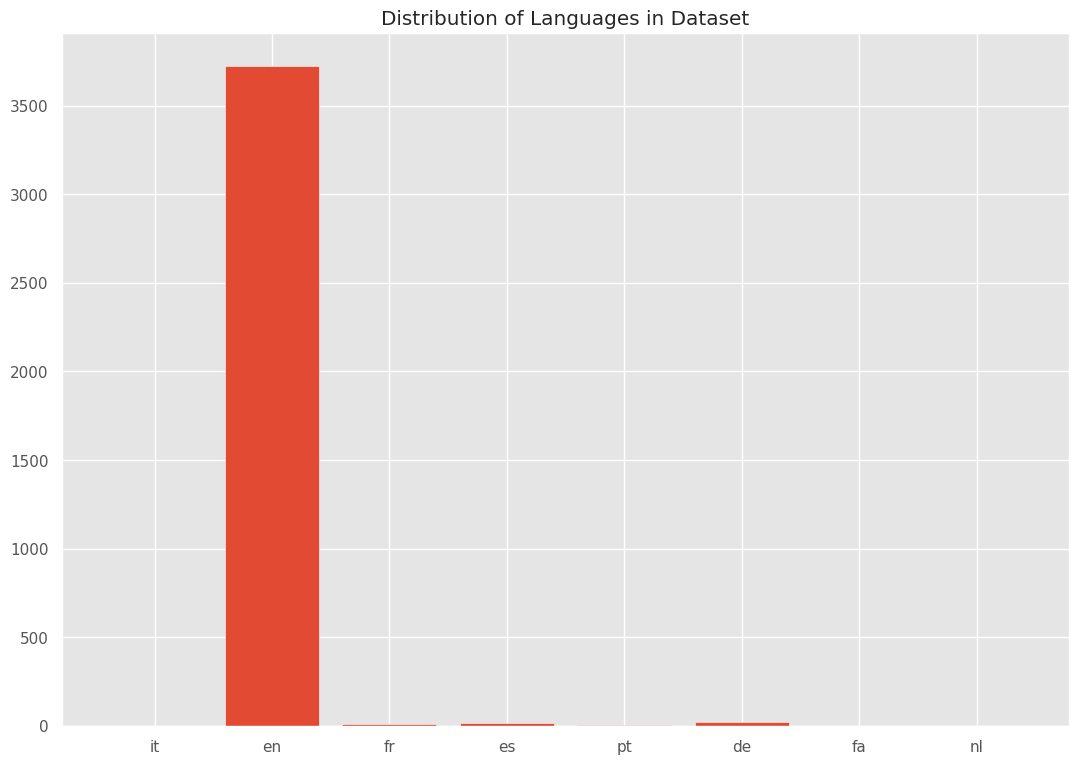

In [ ]:
df['language'] = languages
plt.bar(range(len(languages_dict)), list(languages_dict.values()), align='center')
plt.xticks(range(len(languages_dict)), list(languages_dict.keys()))
plt.title("Distribution of Languages in Dataset")
plt.show()

In [ ]:
df = df[df['language'] == 'en']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3725 entries, 3936 to 1884
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        3725 non-null   int64 
 1   paper_id          3725 non-null   object
 2   doi               3725 non-null   object
 3   abstract          3725 non-null   object
 4   body_text         3725 non-null   object
 5   authors           3725 non-null   object
 6   title             3725 non-null   object
 7   journal           3725 non-null   object
 8   abstract_summary  3725 non-null   object
 9   language          3725 non-null   object
dtypes: int64(1), object(9)
memory usage: 320.1+ KB


In [ ]:
#NLP
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
# import en_core_sci_lg

In [ ]:
import string

punctuations = string.punctuation
stopwords = list(STOP_WORDS)
stopwords[:10]

['this',
 'myself',
 'sometime',
 'on',
 'via',
 'many',
 'back',
 'part',
 'serious',
 'several']

In [ ]:
custom_stop_words = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure',
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.',
    'al.', 'Elsevier', 'PMC', 'CZI'
]

for w in custom_stop_words:
    if w not in stopwords:
        stopwords.append(w)

In [ ]:
pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz


  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.1/en_core_sci_sm-0.5.1.tar.gz (15.9 MB)
  Preparing metadata (setup.py) ... done


In [ ]:
# import en_core_sci_lg
import en_core_sci_sm

In [ ]:
parser = en_core_sci_sm.load(disable=["tagger", "ner"])
parser.max_length = 7000000

def spacy_tokenizer(sentence):
    mytokens = parser(sentence)
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    mytokens = [ word for word in mytokens if word not in stopwords and word not in punctuations ]
    mytokens = " ".join([i for i in mytokens])
    return mytokens

In [ ]:
tqdm.pandas()
df["processed_text"] = df["body_text"].progress_apply(spacy_tokenizer)

NameError: ignored

In [92]:
df= pd.read_csv("data_processed.csv")

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
def vectorize(text, maxx_features):

    vectorizer = TfidfVectorizer(max_features=maxx_features)
    X = vectorizer.fit_transform(text)
    return X

In [94]:
text = df['processed_text'].values
max_features = 2**12

X = vectorize(text, max_features)

In [95]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(X.toarray())
X_reduced.shape

(3725, 1728)

In [96]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans

In [97]:
# from sklearn import metrics
# from scipy.spatial.distance import cdist

# # run kmeans with many different k
# distortions = []
# K = range(2, 30)
# for k in K:
#     k_means = KMeans(n_clusters=k, random_state=42).fit(X_reduced)
#     k_means.fit(X_reduced)
#     distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
#     #print('Found distortion for {} clusters'.format(k))

In [98]:
# X_line = [K[0], K[-1]]
# Y_line = [distortions[0], distortions[-1]]

# # Plot the elbow
# plt.plot(K, distortions, 'b-')
# plt.plot(X_line, Y_line, 'r')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()

In [99]:
from sklearn.cluster import KMeans

In [100]:
k = 20
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
df['y'] = y_pred

In [101]:
from sklearn.manifold import TSNE

tsne = TSNE(verbose=1, perplexity=50)  # Changed perplexity from 100 to 50 per FAQ
X_embedded = tsne.fit_transform(X.toarray())

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 3725 samples in 0.009s...
[t-SNE] Computed neighbors for 3725 samples in 3.006s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3725
[t-SNE] Computed conditional probabilities for sample 2000 / 3725
[t-SNE] Computed conditional probabilities for sample 3000 / 3725
[t-SNE] Computed conditional probabilities for sample 3725 / 3725
[t-SNE] Mean sigma: 0.385634
[t-SNE] KL divergence after 250 iterations with early exaggeration: 108.392189
[t-SNE] KL divergence after 1000 iterations: 2.503476


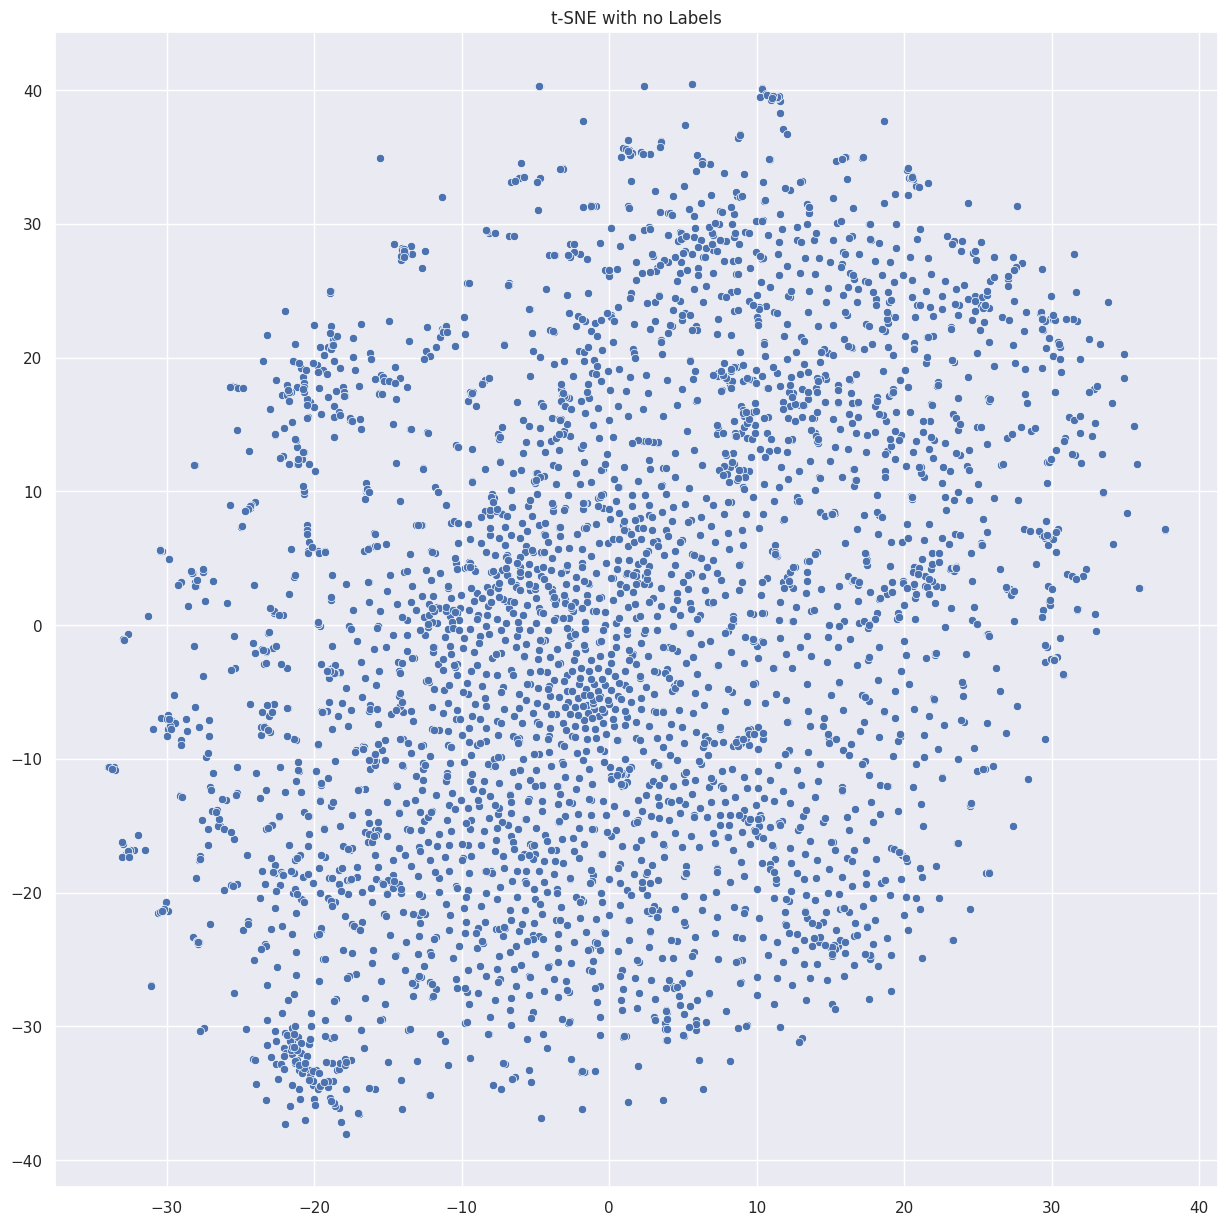

In [102]:
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(15,15)})

# colors
palette = sns.color_palette("bright", 1)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], palette=palette)
plt.title('t-SNE with no Labels')
plt.savefig("t-sne_covid19.png")
plt.show()

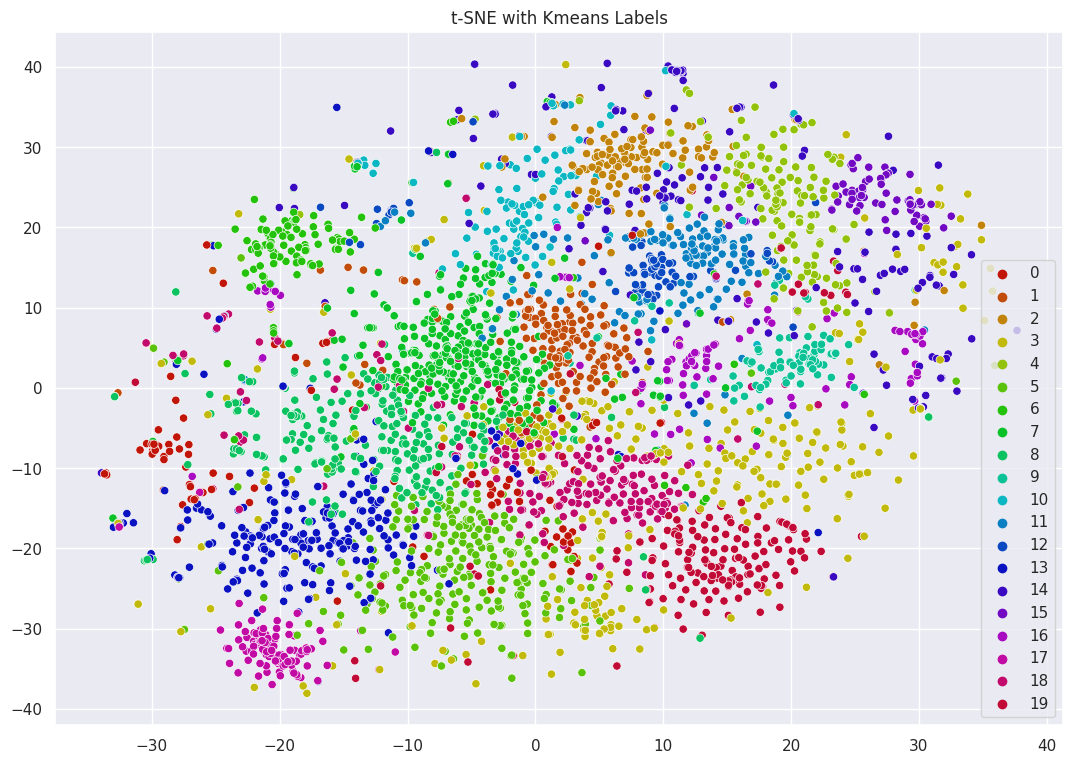

In [103]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(20, l=.4, s=.9)

# plot
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [104]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [105]:
vectorizers = []

for ii in range(0, 20):
    # Creating a vectorizer
    vectorizers.append(CountVectorizer(min_df=5, max_df=0.9, stop_words='english', lowercase=True, token_pattern='[a-zA-Z\-][a-zA-Z\-]{2,}'))

In [106]:
vectorizers[0]

CountVectorizer(max_df=0.9, min_df=5, stop_words='english',
                token_pattern='[a-zA-Z\\-][a-zA-Z\\-]{2,}')

In [107]:
vectorized_data = []

for current_cluster, cvec in enumerate(vectorizers):
    try:
        vectorized_data.append(cvec.fit_transform(df.loc[df['y'] == current_cluster, 'processed_text']))
    except Exception as e:
        print("Not enough instances in cluster: " + str(current_cluster))
        vectorized_data.append(None)

In [108]:
len(vectorized_data)

20

In [109]:
# number of topics per cluster
NUM_TOPICS_PER_CLUSTER = 20


lda_models = []

for ii in range(0, 20):
    # Latent Dirichlet Allocation Model
    lda = LatentDirichletAllocation(n_components=NUM_TOPICS_PER_CLUSTER, max_iter=10, learning_method='online',verbose=False, random_state=42)
    lda_models.append(lda)

lda_models[0]

LatentDirichletAllocation(learning_method='online', n_components=20,
                          random_state=42, verbose=False)

In [110]:
clusters_lda_data = []

for current_cluster, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_cluster))

    if vectorized_data[current_cluster] != None:
        clusters_lda_data.append((lda.fit_transform(vectorized_data[current_cluster])))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [111]:
# Functions for printing keywords for each topic
def selected_topics(model, vectorizer, top_n=3):
    current_words = []
    keywords = []

    for idx, topic in enumerate(model.components_):
        words = [(vectorizer.get_feature_names_out()[i], topic[i]) for i in topic.argsort()[:-top_n - 1:-1]]
        for word in words:
            if word[0] not in current_words:
                keywords.append(word)
                current_words.append(word[0])

    keywords.sort(key = lambda x: x[1])
    keywords.reverse()
    return_values = []
    for ii in keywords:
        return_values.append(ii[0])
    return return_values

In [112]:
all_keywords = []
for current_vectorizer, lda in enumerate(lda_models):
    print("Current Cluster: " + str(current_vectorizer))

    if vectorized_data[current_vectorizer] != None:
        all_keywords.append(selected_topics(lda, vectorizers[current_vectorizer]))

Current Cluster: 0
Current Cluster: 1
Current Cluster: 2
Current Cluster: 3
Current Cluster: 4
Current Cluster: 5
Current Cluster: 6
Current Cluster: 7
Current Cluster: 8
Current Cluster: 9
Current Cluster: 10
Current Cluster: 11
Current Cluster: 12
Current Cluster: 13
Current Cluster: 14
Current Cluster: 15
Current Cluster: 16
Current Cluster: 17
Current Cluster: 18
Current Cluster: 19


In [113]:
all_keywords[0][:10]

['food',
 'women',
 'risk',
 'children',
 'mothers',
 'countries',
 'participants',
 'people',
 'school',
 'pregnant']

In [114]:
len(all_keywords)

20

In [115]:
f=open('topics.txt','w')

count = 0

for ii in all_keywords:

    if vectorized_data[count] != None:
        f.write(', '.join(ii) + "\n")
    else:
        f.write("Not enough instances to be determined. \n")
        f.write(', '.join(ii) + "\n")
    count += 1

f.close()

In [116]:
import pickle

# save the COVID-19 DataFrame
pickle.dump(df, open("df_covid.p", "wb" ))

# save the final t-SNE
pickle.dump(X_embedded, open("X_embedded.p", "wb" ))

# save the labels generate with k-means(20)
pickle.dump(y_pred, open("y_pred.p", "wb" ))

In [117]:

! mkdir lib
! ls
! wget https://raw.githubusercontent.com/rodeketan/TM_COVID/main/call_backs.py
! mv call_backs.py lib/.
! ls lib/

mkdir: cannot create directory ‘lib’: File exists
data_processed.csv	   lib		t-sne_covid-19_interactive.html  y_pred.p
df_covid.p		   sample_data	t-sne_covid19.png
improved_cluster_tsne.png  topics.txt	X_embedded.p
--2023-11-15 00:03:41--  https://raw.githubusercontent.com/rodeketan/TM_COVID/main/call_backs.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3199 (3.1K) [text/plain]
Saving to: ‘call_backs.py’

call_backs.py       100%[===================>]   3.12K  --.-KB/s    in 0s      

2023-11-15 00:03:41 (55.6 MB/s) - ‘call_backs.py’ saved [3199/3199]

call_backs.py  __pycache__


In [118]:
import os

topic_path = os.path.join(os.getcwd(), 'topics.txt')
with open(topic_path) as f:
    topics = f.readlines()

In [119]:
from lib.call_backs import input_callback, selected_code


In [120]:
def input_callback(plot, source, out_text, topics):

    # slider call back for cluster selection
    callback = CustomJS(args=dict(p=plot, source=source, out_text=out_text, topics=topics), code="""
				var key = text.value;
				key = key.toLowerCase();
				var cluster = slider.value;

                var data = source.data;
                var x = data['x'];
                var y = data['y'];
                var x_backup = data['x_backup'];
                var y_backup = data['y_backup'];
                var labels = data['desc'];
                var abstract = data['abstract'];
                var titles = data['titles'];
                var authors = data['authors'];
                var journal = data['journal'];
                if (cluster == '20') {
                    out_text.text = 'Keywords: Slide to specific cluster to see the keywords.';
                    for (var i = 0; i < x.length; i++) {
						if(abstract[i].includes(key) ||
						titles[i].includes(key) ||
						authors[i].includes(key) ||
						journal[i].includes(key)) {
							x[i] = x_backup[i];
							y[i] = y_backup[i];
						} else {
							x[i] = undefined;
							y[i] = undefined;
						}
                    }
                }
                else {
                    out_text.text = 'Keywords: ' + topics[Number(cluster)];
                    for (var i = 0; i < x.length; i++) {
                        if(labels[i] == cluster) {
							if(abstract[i].includes(key) ||
							titles[i].includes(key) ||
							authors[i].includes(key) ||
							journal[i].includes(key)) {
								x[i] = x_backup[i];
								y[i] = y_backup[i];
							} else {
								x[i] = undefined;
								y[i] = undefined;
							}
                        } else {
                            x[i] = undefined;
                            y[i] = undefined;
                        }
                    }
                }
            source.change.emit();
            """)
    return callback

In [124]:
# Required libraries for plot

import pandas as pd
from bokeh.io import output_file, show, output_notebook
from bokeh.models import ColumnDataSource, HoverTool, CustomJS, Slider, TextInput, Div, Paragraph, TapTool
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.layouts import column, row, layout
from bokeh.palettes import Category20
from bokeh.io import curdoc



# Show in the notebook
output_notebook()

# Target labels
y_labels = y_pred

# Data sources
source = ColumnDataSource(data=dict(
    x=X_embedded[:, 0],
    y=X_embedded[:, 1],
    x_backup=X_embedded[:, 0],
    y_backup=X_embedded[:, 1],
    desc=y_labels,
    titles=df['title'],
    authors=df['authors'],
    journal=df['journal'],
    abstract=df['abstract_summary'],
    labels=["C-" + str(x) for x in y_labels],
    links=df['doi']
))

# Hover over information
hover = HoverTool(tooltips=[
    ("Title", "@titles{safe}"),
    ("Author(s)", "@authors{safe}"),
    ("Journal", "@journal"),
    ("Abstract", "@abstract{safe}"),
    ("Link", "@links")
], point_policy="follow_mouse")

# Map colors
mapper = linear_cmap(field_name='desc',
                     palette=Category20[20],
                     low=min(y_labels), high=max(y_labels))
curdoc().theme = 'dark_minimal'
# Prepare the figure
plot = figure(width=1200, height=850,
              tools=[hover, 'pan', 'wheel_zoom', 'box_zoom', 'reset', 'save', 'tap'],
              title="Clustering of the COVID-19 Literature with t-SNE and K-Means",
              toolbar_location="above")
#plot.background_fill_color = "beige"

# Plot settings
scatter = plot.scatter('x', 'y', size=5,
                       source=source,
                       fill_color=mapper,
                       line_alpha=0.3,
                       line_color="black",
                       legend_field='labels')
plot.legend.title = 'Cluster'

# Keywords
text_banner = Paragraph(text='Keywords: Slide to a specific cluster to see the keywords.', height=90)
input_callback_1 = input_callback(plot, source, text_banner, topics)


# Currently selected article
div_curr = Paragraph(text="""Click on a plot to see the link to the article.""", height=150)
callback_selected = CustomJS(args=dict(source=source, current_selection=div_curr), code=selected_code())
taptool = plot.select(type=TapTool)
taptool.callback = callback_selected

# # Widgets
slider = Slider(start=0, end=20, value=20, step=1, title="Cluster #")
keyword = TextInput(title="Search:", value="")


# slider.js_on_change("value", input_callback_1)
# keyword.js_on_change("value", input_callback_1)

slider.js_on_change("value", input_callback_1)
keyword.js_on_change("value", input_callback_1)



# Pass callback arguments
input_callback_1.args["text"] = keyword
input_callback_1.args["slider"] = slider

# Style
div_curr.styles = {'color': '#BF0A30', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}
text_banner.styles = {'color': '#0269A4', 'font-family': 'Helvetica Neue, Helvetica, Arial, sans-serif;', 'font-size': '1.1em'}

# Layout of the page
l = layout([

    [slider, keyword],
    [text_banner],
    [div_curr],
    [plot]
])
l.sizing_mode = "scale_both"

# Show
output_file('t-sne_covid-19_interactive.html')
show(l)
